**操作光谱**
* @Data: 2024-01-09
* @Author: Rui Zhu

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u

---
# Smoothing
* https://specutils.readthedocs.io/en/stable/manipulation.html#smoothing

## 使用kernel进行smooth

方法1: smooth高级封装函数

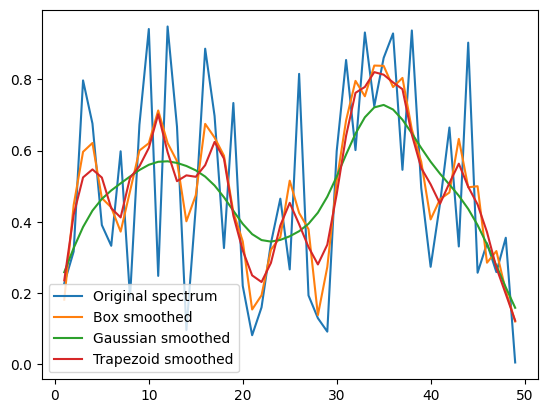

In [17]:
from specutils import Spectrum1D
from specutils.manipulation import box_smooth, gaussian_smooth, trapezoid_smooth

spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm,
                   flux=np.random.default_rng(12345).random(49)*u.Jy)

spec1_bsmooth = box_smooth(spec1, width=3)
spec1_gsmooth = gaussian_smooth(spec1, stddev=3)
spec1_tsmooth = trapezoid_smooth(spec1, width=3)

fig, ax = plt.subplots()
ax.plot(spec1.spectral_axis, spec1.flux, label="Original spectrum")
ax.plot(spec1_bsmooth.spectral_axis, spec1_bsmooth.flux, label="Box smoothed")
ax.plot(spec1_gsmooth.spectral_axis, spec1_gsmooth.flux, label="Gaussian smoothed")
ax.plot(spec1_tsmooth.spectral_axis, spec1_tsmooth.flux, label="Trapezoid smoothed")
ax.legend()

方法2: 使用astropy创建kernel

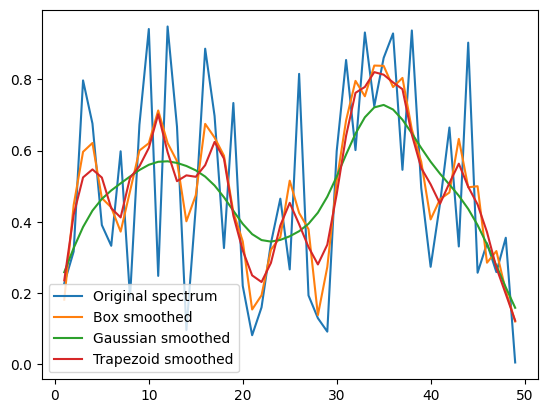

In [18]:
from astropy.convolution import Box1DKernel, Gaussian1DKernel, Trapezoid1DKernel
from specutils.manipulation import convolution_smooth

spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm,
                   flux=np.random.default_rng(12345).random(49) * u.Jy)

box1d_kernel = Box1DKernel(width=3)
gaussian1d_kernel = Gaussian1DKernel(stddev=3)
trapezoid1d_kernel = Trapezoid1DKernel(width=3)

spec1_bsmooth = convolution_smooth(spec1, box1d_kernel)
spec1_gsmooth = convolution_smooth(spec1, gaussian1d_kernel)
spec1_tsmooth = convolution_smooth(spec1, trapezoid1d_kernel)

fig, ax = plt.subplots()
ax.plot(spec1.spectral_axis, spec1.flux, label="Original spectrum")
ax.plot(spec1_bsmooth.spectral_axis, spec1_bsmooth.flux, label="Box smoothed")
ax.plot(spec1_gsmooth.spectral_axis, spec1_gsmooth.flux, label="Gaussian smoothed")
ax.plot(spec1_tsmooth.spectral_axis, spec1_tsmooth.flux, label="Trapezoid smoothed")
ax.legend()

## 使用中值滤波器进行smooth
* 注意：这种方法的flux不恒定，并且误差不进行传递

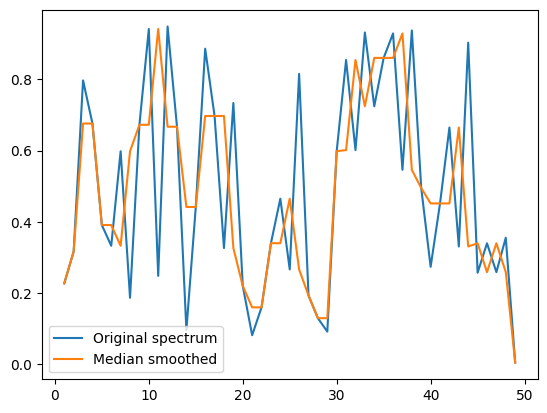

In [28]:
from specutils.manipulation import median_smooth

spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm,
                   flux=np.random.default_rng(12345).random(49) * u.Jy)
spec1_msmooth = median_smooth(spec1, width=3) 

fig, ax = plt.subplots()
ax.plot(spec1.spectral_axis, spec1.flux, label="Original spectrum")
ax.plot(spec1_msmooth.spectral_axis, spec1_msmooth.flux, label="Median smoothed")
ax.legend()

---
# Resampling
* https://specutils.readthedocs.io/en/stable/manipulation.html#resampling

---
# 光谱拼接与组合
* https://specutils.readthedocs.io/en/stable/manipulation.html#splicing-combining-multiple-spectra

---
# 不确定度估计
* https://specutils.readthedocs.io/en/stable/manipulation.html#uncertainty-estimation

---
# S/N Threshold Mask
* https://specutils.readthedocs.io/en/stable/manipulation.html#s-n-threshold-mask

---
# 移动光谱
* https://specutils.readthedocs.io/en/stable/manipulation.html#shifting

---
# 替换区域
* https://specutils.readthedocs.io/en/stable/manipulation.html#replacing-a-region